# HW1

**Author**: Ben Peloquin

**Collaborator**: Marc Harrison
    
**Date**: 20190406

In [111]:
from collections import defaultdict
import h5py
import itertools as it
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.stats as stats
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import time
import tqdm
import sys

# Get access to psych253 utils
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)
from psych253.metrics import *

# Bespoke Hw1 utils
from hw1_utils import *

plt.style.use('ggplot')

%matplotlib inline

Load data

In [4]:
data_fp = "ventral_neural_data.hdf5"
d_ventral = h5py.File(data_fp, 'r')
print(d_ventral.keys())

[u'image_meta', u'images', u'neural_meta', u'time_averaged', u'time_averaged_trial_averaged', u'time_binned', u'time_binned_trial_averaged']


Utils

In [93]:
#let's get the IT neural data -- time and trial averaged
d_neural = d_ventral['time_averaged_trial_averaged']
it_neurons = d_ventral['neural_meta']['IT_NEURONS']
d_it_neurons = d_neural[:, it_neurons]

Basic data

In [94]:
d_time_averaged = d_ventral['time_averaged']
print(d_time_averaged['variation_level_0'].shape)
print(d_time_averaged['variation_level_3'].shape)
print(d_time_averaged['variation_level_6'].shape)
print("Reminder about dims:")
print(list(d_time_averaged['variation_level_0'].dims.keys()))

(28, 640, 296)
(51, 2560, 296)
(47, 2560, 296)
Reminder about dims:
[<"trial" dimension 0 of HDF5 dataset at 112333737232>, <"image" dimension 1 of HDF5 dataset at 112333737232>, <"neuron" dimension 2 of HDF5 dataset at 112333737232>]


## Problem 1.1: Reliability computation on time-averaged responses

Outstanding things (Ben / Marc):
* Do we want to aggregate over conditions?
* Can we use random indices permutations for all neurons? (for runtime efficiency)

### 1.1.a Reliability by neuron
* First compute the reliability for each neuron using the methods described in the class
* Perform a significance test on the population of all the neurons to determine whether the population is significantly reliable or not

In the report, please describe your methods for computing the reliability, choose your own significance level, and report the results of significance test properly (refer to section 3 for details).

[BP] We'll use `split-half reliability` to compute reliability for each neuron. This means we're going to look at average activation for each neuron, aggregating over objects and conditions.

Remember from class we concluded that `having num_splits ~ 10 * num_trials is good enough`



For this first question, we're going to aggregate over specific images, trials and conditions.

In [137]:
with open("pickles_from_Marc_20190421/1.1.a.p", "rb") as fp:
    d_all_var_levels = pickle.load(fp)
results = {}
for lvl, res in d_all_var_levels.items():
    results[lvl] = res

In [138]:
if False:
    run_type = 'efficient'
    variation_levels = [0]
    results = {}
    t0 = time.time()
    for lvl in variation_levels:
        results[lvl] = get_reliability_by_variation_level(d_time_averaged, lvl, type_=run_type)
    print("Runtime: {}".format(time.time() - t0))

In [139]:
def plot_neuron_reliability_at_level(level, means, stds):
    neurons = np.arange(296)
    plt.plot(neurons, means)
    plt.fill_between(neurons, means - stds, means + stds, color='b', alpha = 0.2)
    plt.ylabel("Correlation")
    plt.xlabel("Neuron")
    plt.title("Variation level {}".format(level))
    return plt

<module 'matplotlib.pyplot' from '/Users/benpeloquin/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

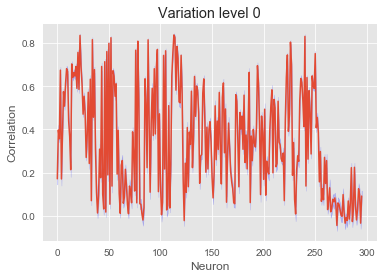

In [140]:
plot_neuron_reliability_at_level(0, results[0][0], results[0][1])

<module 'matplotlib.pyplot' from '/Users/benpeloquin/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

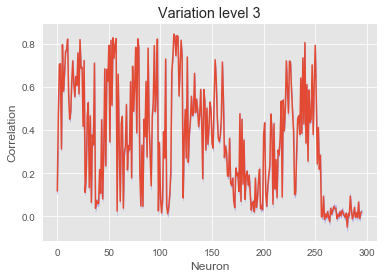

In [141]:
plot_neuron_reliability_at_level(3, results[3][0], results[3][1])

<module 'matplotlib.pyplot' from '/Users/benpeloquin/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

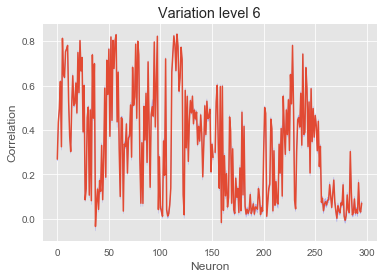

In [142]:
plot_neuron_reliability_at_level(6, results[6][0], results[6][1])

### Population-level reliability

We can test this formally assessing whether the population average is significantly different from 0.

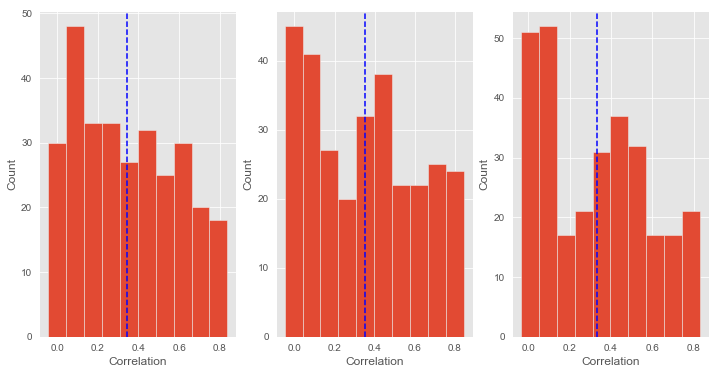

In [143]:
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.hist(results[0][0])
plt.ylabel("Count")
plt.xlabel("Correlation")
plt.axvline(x=np.mean(results[0][0]), c='blue', ls='--')

plt.subplot(132)
plt.hist(results[3][0])
plt.ylabel("Count")
plt.xlabel("Correlation")
plt.axvline(x=np.mean(results[3][0]), c='blue', ls='--')

plt.subplot(133)
plt.hist(np.nan_to_num(results[6][0]))
plt.ylabel("Count")
plt.xlabel("Correlation")
plt.axvline(x=np.mean(np.nan_to_num(results[6][0])), c='blue', ls='--')

In [144]:
for var_level in [0, 3, 6]:    
    print(stats.ttest_1samp(np.nan_to_num(results[var_level][0]), 0.))

Ttest_1sampResult(statistic=24.318922365628666, pvalue=1.8899296803534524e-72)
Ttest_1sampResult(statistic=23.290344982567177, pvalue=8.379803357764619e-69)
Ttest_1sampResult(statistic=22.990664589049445, pvalue=9.885924465373769e-68)


* To compute the reliability for a single neuron we used the split-half using `20 splits` with `10 trials` each. For each neuron this gave 20 reliability estimates we used to compute the mean and std.
* We examined the distribution over mean reliability measures for the entire population in the histogram plot and performed a t-test to assess whether the average reliability was significantly different than 0. We found that the population was significantly reliable.
```
    Var 0 
     t(295) = 24.318, p < 1e-60
 
    Var 3
    t(295) = 23.29, p < 1e-60
 
    Var 6
    t(295) = 22.99, p < 1e-60
```

### 1.1.b Reliability by areas

Test whether reliability of V4 neurons is significantly different from that of IT neurons.
* Choose a significance level and report the significance test results properly. 


In [145]:
IT_neurons = d_ventral['neural_meta']['IT_NEURONS']
v4_neurons = d_ventral['neural_meta']['V4_NEURONS']
d_it = np.array(d_time_averaged['variation_level_0'])[:, :, IT_neurons]
d_v4 = np.array(d_time_averaged['variation_level_0'])[:, :, v4_neurons]

In [146]:
it_reliabilities = get_all_neuron_reliabilities(d_it, 40, 20)
v4_reliabilities = get_all_neuron_reliabilities(d_v4, 40, 20)


 92%|█████████▏| 155/168 [00:33<00:02,  5.40it/s]


100%|██████████| 168/168 [00:36<00:00,  4.87it/s]

100%|██████████| 128/128 [00:10<00:00, 13.10it/s]


In [154]:
def hist_plot(a, b, a_name=None, b_name=None):
    l0 = plt.hist(a, bins=20);
    l1 = plt.hist(b, bins=20, alpha=0.5);
    if a_name is not None and b_name is not None:
        plt.legend([l0[2][0], l1[2][0]], [a_name, b_name])
    plt.xlabel('Reliabilities (r)')
    plt.ylabel('Count')
    
def hist_plot2(datas, data_names, alpha=0.5):
    for d, name in zip(datas, data_names):
        plt.hist(d, bins=20, alpha=alpha)
        plt.xlabel('Reliabilities (r)')
        plt.ylabel('Count')
    plt.legend(data_names)  

In [155]:
it_means = it_reliabilities.mean(1)
v4_means = v4_reliabilities.mean(1)
it_std = it_reliabilities.std(1)
v4_std = v4_reliabilities.std(1)

Let's create a bar plot with error bars over our average reliabilities by area. Note that we are aggregating over neuron means.

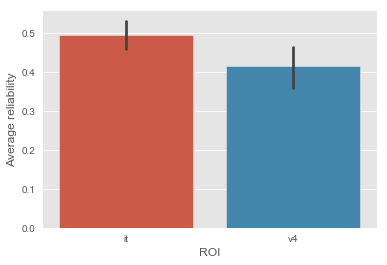

In [156]:
df_bar_plot = pd.DataFrame({
    "ROI": ["it" for _ in range(len(it_means))] + ["v4" for _ in range(len(v4_means))],
    "Average reliability": it_means.tolist() + v4_means.tolist()})
sns.barplot(x="ROI", y="Average reliability", ci=95, data=df_bar_plot)

But let's look the population reliabilities too!

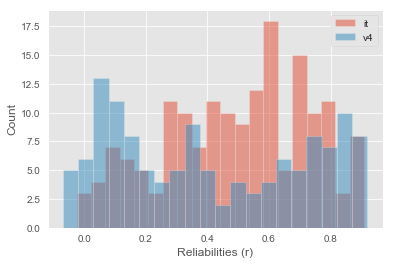

In [157]:
hist_plot2([it_means, v4_means], ['it', 'v4'])

In [158]:
print(np.std(it_means))
print(np.std(v4_means))

print(np.mean(it_std))
print(np.mean(v4_std))

0.23602578
0.3090233
0.018947152
0.019631188


Just a note that we can inspect both the population level variance by taking the standard deviation over area means for each area. We find that, in accordance with our histogram, IT population is less variable than V4. However, if we inspect the average variance for *individual neurons* by taking the mean of the split-half variances we see that there don't appear to be significant differences between populations!

In [159]:
n1 = len(it_means)
n2 = len(v4_means)
dof = n1 + n2 - 2
print(dof)
stats.ttest_ind(it_means, v4_means, equal_var=False)

294


Ttest_indResult(statistic=2.4452137320767555, pvalue=0.015227368229589412)

Under a two-sample t-test the IT neurons appear to be significnatly more reliable at a significance level of 0.05 for the variation 0 data.

```
t(294) = 2.45, p = .015
```


### 1.1.c Reliability by animal

Validate that neurons in each animal and also each electrode array agenerating reliable responses.
* Choose a significance level and report the significance test results properly. 
* After grouping neurons by animals, please perform significance test to both animals and report the results. Similarly, please also plot a histogram of reliability of neurons in two animals


In [160]:
chabo_idxs = d_ventral['neural_meta']['ANIMAL_INFO'][:] == 'Chabo'
tito_idxs = d_ventral['neural_meta']['ANIMAL_INFO'][:] == 'Tito'
it_idxs = d_ventral['neural_meta']["IT_NEURONS"][:] == "IT"
d_chabo = d_time_averaged['variation_level_0'][:, :, chabo_idxs]
d_tito = d_time_averaged['variation_level_0'][: , :, tito_idxs]

/Users/benpeloquin/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until


In [161]:
# Get reliabilites
chabo_reliabilities = get_all_neuron_reliabilities(d_chabo, 20, 10)
tito_reliabilities = get_all_neuron_reliabilities(d_tito, 20, 10)


 96%|█████████▌| 161/168 [00:17<00:00, 11.20it/s]


100%|██████████| 168/168 [00:17<00:00,  9.52it/s]

In [163]:
# Get means
chabo_means = chabo_reliabilities.mean(1)
tito_means = tito_reliabilities.mean(1)
chabo_std = chabo_reliabilities.std(1)
tito_std = tito_reliabilities.std(1)

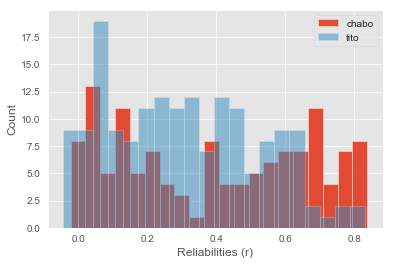

In [164]:
hist_plot(chabo_means, tito_means, 'chabo', 'tito')

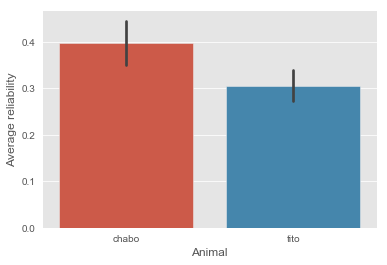

In [165]:
df_bar_plot = pd.DataFrame({
    "Animal": ["chabo" for _ in range(len(chabo_means))] + ["tito" for _ in range(len(tito_means))],
    "Average reliability": chabo_means.tolist() + tito_means.tolist()})
sns.barplot(x="Animal", y="Average reliability", ci=95, data=df_bar_plot)

In [166]:
n1 = len(chabo_means)
n2 = len(tito_means)
dof = n1 + n2 - 2
print(dof)
stats.ttest_ind(chabo_means, tito_means, equal_var=False)

294


Ttest_indResult(statistic=3.1601525908843624, pvalue=0.0017841030854144518)

Under a two-sample t-test the Chabo appears to be significantly more reliable at a significance leve of 0.05 for variation 0 data.

```
t(294) = 3.16, p < .001
```


### 1.1.d Reliability by electrode arrays

You need to combine this information with “ANIMAL INFO” to group the neurons by six electrode arrays, e.g. the neurons belonging to “Chabo” and array “P”

In [167]:
import itertools as it

animals = ["Chabo", "Tito"]
areas = ["P", "M", "A"]
combinations = list(it.product(animals, areas))

# Create filters
filters = {}
for animal, area in combinations:
    animal_filter = d_ventral['neural_meta']['ANIMAL_INFO'][:] == animal
    area_filter = d_ventral['neural_meta']['ARRAY_INFO'][:] == area
    combination_filter = animal_filter & area_filter
    filters[animal + "_" + area] = combination_filter

In [168]:
# Get reliability data
results = {}
for animal_area, curr_filter in filters.items():
    d = d_time_averaged["variation_level_0"][:, :, curr_filter]
    results[animal_area] = get_all_neuron_reliabilities(d, 20, 10).mean(1)


100%|██████████| 70/70 [00:03<00:00, 25.37it/s]

100%|██████████| 40/40 [00:00<00:00, 53.72it/s]

Text(0.5,1,'Animal by array reliability')

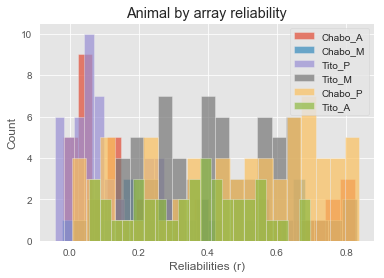

In [169]:
hist_plot2(list(results.values()), list(results.keys()), 0.7)
plt.title("Animal by array reliability")

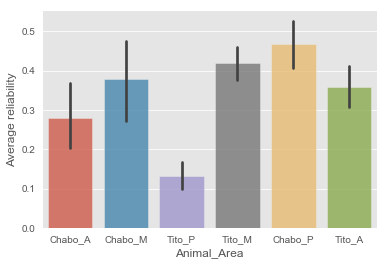

In [170]:
names = []
values = []
for nam, res in results.items():
    names.extend([nam for _ in range(len(res))])
    values.extend(res)

df_bar_plot_animal_area = pd.DataFrame({"Animal_Area": names, "Average reliability": values})
sns.barplot(x="Animal_Area", y="Average reliability", alpha=0.8, ci=95, data=df_bar_plot_animal_area)

## Problem 1.1: Reliability computation on time-averaged responses

### 1.2.a Reliability by areas in each of 20ms bins

In [171]:
ms_groups = d_ventral['time_binned'].keys(); print(ms_groups)
d_time_binned = d_ventral['time_binned']

[u'0ms', u'100ms', u'120ms', u'140ms', u'160ms', u'180ms', u'200ms', u'20ms', u'40ms', u'60ms', u'80ms']


In [181]:
if os.path.exists("./q1_2_a.pickle"):
    with open("q1_2_a.pickle", 'rb') as fp:
        d_all_ms = pickle.load(fp)
else:
    var_level = 0
    d_all_ms = {}
    for ms in ms_groups:
        d_all_ms[ms] = get_reliability_by_variation_level(d_time_binned[ms], var_level)
        
    with open("q1_2_a.pickle", "wb") as fp:
        pickle.dump(d_all_ms, fp) 

In [182]:
# plot variability across time color by neuron
d_time_binned = list()
for ms, (means, stds, _) in tqdm.tqdm(d_all_ms.items()):
    for neuron_idx in range(len(means)):
        d_time_binned.append({
            'ms': ms,
            'neuron_id': neuron_idx,
            'mean': means[neuron_idx],
            'sem': stds[neuron_idx]
        })
df_time_binned = pd.DataFrame(d_time_binned)
print(df_time_binned.columns)



  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:00<00:00, 1856.56it/s]

Index([u'mean', u'ms', u'neuron_id', u'sem'], dtype='object')


In [183]:
IT_idxs = d_ventral['neural_meta']['IT_NEURONS'][:]
V4_idxs = d_ventral['neural_meta']['V4_NEURONS'][:]

def group_color(neuron_id):
    return 'IT' if neuron_id in IT_idxs else 'V4'

def ms2int(ms_str):
    return int(ms_str[:-2])

def add_jitter(val, scaler=3):
    return val + scaler*np.random.uniform(-1, 1)
    
df_time_binned['ROI'] = df_time_binned['neuron_id'].apply(group_color)
df_time_binned['ms_int'] = df_time_binned['ms'].apply(ms2int)
df_time_binned['ms_int_jitter'] = df_time_binned['ms_int'].apply(add_jitter)

In [184]:
V4_idxs[-40:]

array([256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268,
       269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281,
       282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294,
       295])

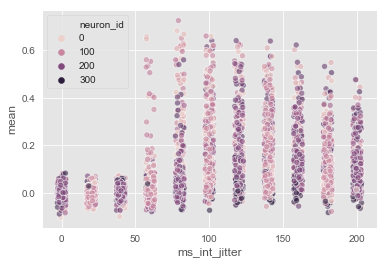

In [185]:
sns.scatterplot(x='ms_int_jitter', y='mean', hue='neuron_id', alpha=0.6, data=df_time_binned.sort_values(by='ms_int'))

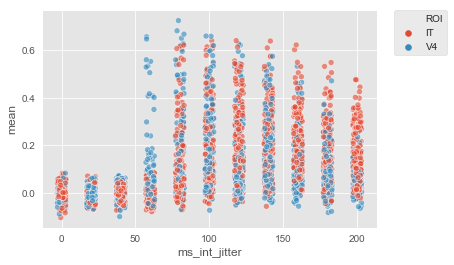

In [186]:
# plot variability across time color area
sns.scatterplot(x='ms_int_jitter', y='mean', hue='ROI', alpha=0.6, data=df_time_binned.sort_values(by='ms_int'))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

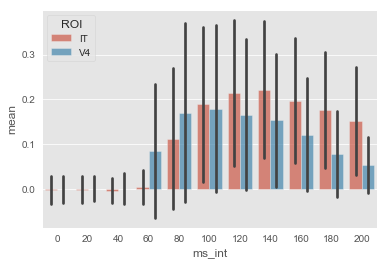

In [187]:
# One more look aggregating by ROI
sns.barplot(y='mean', x='ms_int', hue='ROI', ci="sd", alpha=0.7, data=df_time_binned.sort_values(by='ms_int'))

**Not** everything is OK! Reliability for all neurons (in both V4 and IT) are really poor prior to 60ms! This is because significant processing doesn't occur until after some delay (clearly after 40ms).

Let's check over areas aggregated..

### 1.2.b Diagnose the problem

**Diagnose quantitatively instead of looking at hint**

Note that in the first plot from `1.2.a` there is a cluster of darker neurons that are all consistently really low for reliability... If we go back to our very first plot of all neuron reliabilities averaged across time bins we see that there is a cluster of neurons (the last bunch) which are really low!

### 1.2.c Difference in V4 and IT neurons

In [188]:
bad_v4_neuron_ids = V4_idxs[-40:]
df_time_binned_good = df_time_binned[~df_time_binned["neuron_id"].isin(bad_v4_neuron_ids)]
df_time_binned_bad = df_time_binned[df_time_binned["neuron_id"].isin(bad_v4_neuron_ids)]

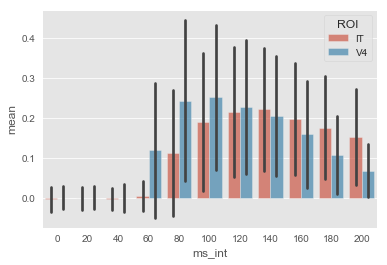

In [189]:
sns.barplot(y='mean', x='ms_int', hue='ROI', ci='sd', 
            alpha=0.7, data=df_time_binned_good.sort_values(by='ms_int'))

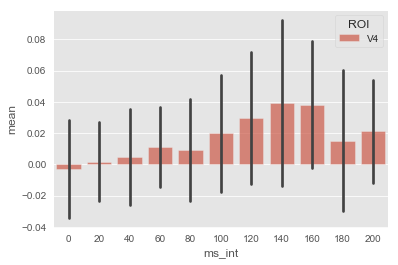

In [191]:
sns.barplot(y='mean', x='ms_int', hue='ROI', ci='sd', 
            alpha=0.7, data=df_time_binned_bad.sort_values(by='ms_int'))

Note that when we remove the bad ones V4 becomes reliable earlier than IT -- V4 becomes reliable at about 80ms while IT only becomes reliable around 100ms. Both remain reliable "longer" when we remove the "bad" neurons, however V4 appears to decline somewhat.

## Problem 1.2: Classifiers

Classifying one of the eight basic object categories in the images. Note that the HW assignment is ambiguous in terms of whether I should treat this as a multi-way classification problem or an eight way classifier. I'm going to default to the latter so all our accuracies reflect an 8-way classification scheme.


### Problem 1.2.1: Regularization

**Note** in the problem description it says that 

In [192]:
# Time averaged trial data
X = d_ventral['time_averaged_trial_averaged'][:]
# Categories
y = d_ventral['image_meta']['category'][:]
assert(X.shape[0] == y.shape[0])

#### Problem 1.2.1.a: Explore lots of models

First we're going to examine performance reliability across train/test split sizes. We'll consider a single baseline model (linear svc without regularization) and compute average accuracy and d_prime.

In [193]:
# Run Params
test_split_sizes = np.arange(0.1, 0.9, 1e-01)
baseline = LinearSVC(C=float(1e-10))  # Baseline uses no (minimal) regularization
n_splits = 100 # Run each splits sie 100 times...

In [194]:
# Train models
t0 = time.time()
d_test_splits = {}

for i, test_split_size in enumerate(test_split_sizes):
    model_cms, model_runtimes = \
        run_models_over_n_splits([baseline], n_splits, X, y, test_split_size)
    cms = model_cms.values()[0]
    d_test_splits[str(test_split_size)] = evaluate_results(np.stack(cms), set(y))
print("Run time {}".format(time.time() - t0))



  0%|          | 0/100 [00:00<?, ?it/s]

  2%|▏         | 2/100 [00:00<00:08, 12.03it/s]

Running 1 models over 100 splits.




  4%|▍         | 4/100 [00:00<00:08, 11.98it/s]

  6%|▌         | 6/100 [00:00<00:07, 12.33it/s]

  8%|▊         | 8/100 [00:00<00:07, 12.41it/s]

 10%|█         | 10/100 [00:00<00:07, 12.79it/s]

 12%|█▏        | 12/100 [00:00<00:06, 13.38it/s]

 14%|█▍        | 14/100 [00:01<00:06, 13.47it/s]

 16%|█▌        | 16/100 [00:01<00:06, 12.48it/s]

 18%|█▊        | 18/100 [00:01<00:06, 12.24it/s]

 20%|██        | 20/100 [00:01<00:06, 12.68it/s]

 22%|██▏       | 22/100 [00:01<00:05, 13.30it/s]

 24%|██▍       | 24/100 [00:01<00:05, 13.41it/s]

 26%|██▌       | 26/100 [00:01<00:05, 13.97it/s]

 28%|██▊       | 28/100 [00:02<00:05, 13.93it/s]

 30%|███       | 30/100 [00:02<00:05, 13.79it/s]

 32%|███▏      | 32/100 [00:02<00:05, 12.46it/s]

 34%|███▍      | 34/100 [00:02<00:05, 12.14it/s]

 36%|███▌      | 36/100 [00:02<00:05, 12.70it/s]

 38%|███▊      | 38/100 [00:02<00:04, 12.44it/s]

 40%|████      | 40/100 [00:03<00:05, 11.91it/s]

 42%|████▏     | 42/100 [00:03<00:04, 11.88it/s]

 

Running 1 models over 100 splits.




  4%|▍         | 4/100 [00:00<00:07, 12.74it/s]

  6%|▌         | 6/100 [00:00<00:07, 12.53it/s]

  8%|▊         | 8/100 [00:00<00:06, 13.39it/s]

 10%|█         | 10/100 [00:00<00:06, 13.85it/s]

 12%|█▏        | 12/100 [00:00<00:07, 12.37it/s]

 14%|█▍        | 14/100 [00:01<00:07, 12.03it/s]

 16%|█▌        | 16/100 [00:01<00:06, 12.05it/s]

 18%|█▊        | 18/100 [00:01<00:07, 11.55it/s]

 20%|██        | 20/100 [00:01<00:07, 10.86it/s]

 22%|██▏       | 22/100 [00:01<00:06, 11.36it/s]

 24%|██▍       | 24/100 [00:01<00:06, 11.76it/s]

 26%|██▌       | 26/100 [00:02<00:06, 12.07it/s]

 28%|██▊       | 28/100 [00:02<00:05, 12.32it/s]

 30%|███       | 30/100 [00:02<00:05, 12.80it/s]

 32%|███▏      | 32/100 [00:02<00:05, 12.75it/s]

 34%|███▍      | 34/100 [00:02<00:05, 12.77it/s]

 36%|███▌      | 36/100 [00:02<00:05, 12.57it/s]

 38%|███▊      | 38/100 [00:03<00:04, 12.64it/s]

 40%|████      | 40/100 [00:03<00:04, 12.05it/s]

 42%|████▏     | 42/100 [00:03<00:04, 12.17it/s]

 

Running 1 models over 100 splits.




  4%|▍         | 4/100 [00:00<00:05, 16.69it/s]

  6%|▌         | 6/100 [00:00<00:05, 16.02it/s]

  8%|▊         | 8/100 [00:00<00:05, 16.04it/s]

 10%|█         | 10/100 [00:00<00:06, 14.72it/s]

 12%|█▏        | 12/100 [00:00<00:06, 13.99it/s]

 14%|█▍        | 14/100 [00:00<00:06, 13.77it/s]

 16%|█▌        | 16/100 [00:01<00:06, 13.83it/s]

 18%|█▊        | 18/100 [00:01<00:06, 13.58it/s]

 20%|██        | 20/100 [00:01<00:05, 13.43it/s]

 22%|██▏       | 22/100 [00:01<00:05, 13.40it/s]

 24%|██▍       | 24/100 [00:01<00:05, 14.14it/s]

 26%|██▌       | 26/100 [00:01<00:04, 14.89it/s]

 28%|██▊       | 28/100 [00:01<00:04, 15.20it/s]

 30%|███       | 30/100 [00:02<00:04, 15.79it/s]

 32%|███▏      | 32/100 [00:02<00:04, 16.29it/s]

 34%|███▍      | 34/100 [00:02<00:03, 16.89it/s]

 36%|███▌      | 36/100 [00:02<00:03, 16.10it/s]

 38%|███▊      | 38/100 [00:02<00:04, 15.23it/s]

 40%|████      | 40/100 [00:02<00:04, 14.89it/s]

 42%|████▏     | 42/100 [00:02<00:03, 14.81it/s]

 

Running 1 models over 100 splits.




  4%|▍         | 4/100 [00:00<00:06, 14.67it/s]

  6%|▌         | 6/100 [00:00<00:06, 14.93it/s]

  8%|▊         | 8/100 [00:00<00:05, 15.67it/s]

 10%|█         | 10/100 [00:00<00:05, 15.75it/s]

 13%|█▎        | 13/100 [00:00<00:05, 17.06it/s]

 15%|█▌        | 15/100 [00:00<00:05, 15.63it/s]

 17%|█▋        | 17/100 [00:01<00:05, 14.65it/s]

 19%|█▉        | 19/100 [00:01<00:05, 14.34it/s]

 21%|██        | 21/100 [00:01<00:05, 14.18it/s]

 23%|██▎       | 23/100 [00:01<00:05, 14.37it/s]

 25%|██▌       | 25/100 [00:01<00:05, 14.22it/s]

 27%|██▋       | 27/100 [00:01<00:05, 14.24it/s]

 29%|██▉       | 29/100 [00:01<00:04, 14.47it/s]

 31%|███       | 31/100 [00:02<00:04, 14.40it/s]

 33%|███▎      | 33/100 [00:02<00:04, 15.22it/s]

 35%|███▌      | 35/100 [00:02<00:03, 16.31it/s]

 37%|███▋      | 37/100 [00:02<00:03, 16.89it/s]

 39%|███▉      | 39/100 [00:02<00:03, 17.14it/s]

 41%|████      | 41/100 [00:02<00:03, 17.63it/s]

 43%|████▎     | 43/100 [00:02<00:03, 17.70it/s]

 

Running 1 models over 100 splits.




  4%|▍         | 4/100 [00:00<00:05, 17.80it/s]

  6%|▌         | 6/100 [00:00<00:05, 17.57it/s]

  8%|▊         | 8/100 [00:00<00:05, 17.98it/s]

 11%|█         | 11/100 [00:00<00:04, 19.52it/s]

 14%|█▍        | 14/100 [00:00<00:04, 20.22it/s]

 17%|█▋        | 17/100 [00:00<00:03, 21.27it/s]

 20%|██        | 20/100 [00:00<00:03, 21.99it/s]

 23%|██▎       | 23/100 [00:01<00:03, 22.90it/s]

 26%|██▌       | 26/100 [00:01<00:03, 21.63it/s]

 29%|██▉       | 29/100 [00:01<00:03, 21.58it/s]

 32%|███▏      | 32/100 [00:01<00:03, 21.47it/s]

 35%|███▌      | 35/100 [00:01<00:03, 20.54it/s]

 38%|███▊      | 38/100 [00:01<00:03, 20.09it/s]

 41%|████      | 41/100 [00:01<00:02, 20.44it/s]

 44%|████▍     | 44/100 [00:02<00:02, 20.97it/s]

 47%|████▋     | 47/100 [00:02<00:02, 21.08it/s]

 50%|█████     | 50/100 [00:02<00:02, 20.94it/s]

 53%|█████▎    | 53/100 [00:02<00:02, 19.93it/s]

 56%|█████▌    | 56/100 [00:02<00:02, 20.91it/s]

 59%|█████▉    | 59/100 [00:02<00:01, 21.61it/s]

 

Running 1 models over 100 splits.




  5%|▌         | 5/100 [00:00<00:04, 22.31it/s]

  8%|▊         | 8/100 [00:00<00:04, 21.95it/s]

 11%|█         | 11/100 [00:00<00:03, 22.88it/s]

 14%|█▍        | 14/100 [00:00<00:03, 23.25it/s]

 17%|█▋        | 17/100 [00:00<00:03, 22.90it/s]

 20%|██        | 20/100 [00:00<00:03, 23.09it/s]

 23%|██▎       | 23/100 [00:00<00:03, 23.86it/s]

 26%|██▌       | 26/100 [00:01<00:03, 24.29it/s]

 29%|██▉       | 29/100 [00:01<00:03, 23.55it/s]

 32%|███▏      | 32/100 [00:01<00:02, 23.66it/s]

 35%|███▌      | 35/100 [00:01<00:02, 23.96it/s]

 38%|███▊      | 38/100 [00:01<00:02, 24.69it/s]

 41%|████      | 41/100 [00:01<00:02, 25.38it/s]

 44%|████▍     | 44/100 [00:01<00:02, 24.90it/s]

 47%|████▋     | 47/100 [00:01<00:02, 23.86it/s]

 50%|█████     | 50/100 [00:02<00:02, 22.22it/s]

 53%|█████▎    | 53/100 [00:02<00:02, 21.62it/s]

 56%|█████▌    | 56/100 [00:02<00:02, 20.78it/s]

 59%|█████▉    | 59/100 [00:02<00:01, 21.46it/s]

 62%|██████▏   | 62/100 [00:02<00:01, 22.63it/s]



Running 1 models over 100 splits.




  8%|▊         | 8/100 [00:00<00:02, 33.60it/s]

 11%|█         | 11/100 [00:00<00:02, 30.74it/s]

 15%|█▌        | 15/100 [00:00<00:02, 31.37it/s]

 19%|█▉        | 19/100 [00:00<00:02, 31.79it/s]

 23%|██▎       | 23/100 [00:00<00:02, 31.98it/s]

 26%|██▌       | 26/100 [00:00<00:02, 30.07it/s]

 29%|██▉       | 29/100 [00:00<00:02, 28.43it/s]

 32%|███▏      | 32/100 [00:01<00:02, 28.76it/s]

 36%|███▌      | 36/100 [00:01<00:02, 29.82it/s]

 40%|████      | 40/100 [00:01<00:01, 30.68it/s]

 44%|████▍     | 44/100 [00:01<00:01, 31.10it/s]

 48%|████▊     | 48/100 [00:01<00:01, 31.69it/s]

 52%|█████▏    | 52/100 [00:01<00:01, 32.21it/s]

 56%|█████▌    | 56/100 [00:01<00:01, 32.40it/s]

 60%|██████    | 60/100 [00:01<00:01, 29.43it/s]

 63%|██████▎   | 63/100 [00:02<00:01, 28.36it/s]

 66%|██████▌   | 66/100 [00:02<00:01, 28.11it/s]

 69%|██████▉   | 69/100 [00:02<00:01, 26.84it/s]

 72%|███████▏  | 72/100 [00:02<00:01, 26.74it/s]

 76%|███████▌  | 76/100 [00:02<00:00, 28.19it/s]


Running 1 models over 100 splits.




  8%|▊         | 8/100 [00:00<00:02, 38.99it/s]

 12%|█▏        | 12/100 [00:00<00:02, 37.88it/s]

 16%|█▌        | 16/100 [00:00<00:02, 37.95it/s]

 20%|██        | 20/100 [00:00<00:02, 38.30it/s]

 24%|██▍       | 24/100 [00:00<00:01, 38.41it/s]

 28%|██▊       | 28/100 [00:00<00:01, 38.32it/s]

 32%|███▏      | 32/100 [00:00<00:01, 38.48it/s]

 37%|███▋      | 37/100 [00:00<00:01, 39.47it/s]

 41%|████      | 41/100 [00:01<00:01, 39.40it/s]

 45%|████▌     | 45/100 [00:01<00:01, 39.37it/s]

 49%|████▉     | 49/100 [00:01<00:01, 38.95it/s]

 53%|█████▎    | 53/100 [00:01<00:01, 38.67it/s]

 57%|█████▋    | 57/100 [00:01<00:01, 38.93it/s]

 61%|██████    | 61/100 [00:01<00:00, 39.19it/s]

 65%|██████▌   | 65/100 [00:01<00:00, 39.22it/s]

 69%|██████▉   | 69/100 [00:01<00:00, 39.42it/s]

 73%|███████▎  | 73/100 [00:01<00:00, 39.30it/s]

 77%|███████▋  | 77/100 [00:01<00:00, 39.09it/s]

 81%|████████  | 81/100 [00:02<00:00, 38.93it/s]

 85%|████████▌ | 85/100 [00:02<00:00, 38.98it/s]


Run time 43.6860601902


In [196]:
# Gather data
d_splits = []
for split, res in d_test_splits.items():
    accuracies = res['accuracy_by_split']
    for i in range(len(accuracies)):
        d_splits.append({
            "run_num": i,
            "split": split,
            "accuracy": accuracies[i]
        })
df_splits = pd.DataFrame(d_splits)
df_splits['split'] = df_splits['split'].apply(lambda x: round(float(x), 2))

Let's have a quick look at mean and variance over our splits...

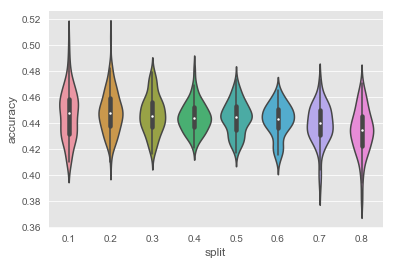

In [197]:
sns.violinplot(x='split', y='accuracy', data=df_splits)

<BarContainer object of 8 artists>

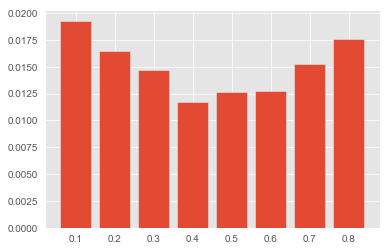

In [198]:
df_stds = df_splits[['split', 'accuracy']].groupby('split') \
    .aggregate({np.std})['accuracy'] \
    .reset_index()
plt.bar([str(x) for x in df_stds['split']], df_stds['std'])

We can verify that we get the most stable estimates with a test size of 0.3 or 0.4. I'd be curious to hear a theoretical justification for why a particualr test parition size might be better worse.

Let's run a model comparison. We'll compare our baseline model to L1 and L2 SVMs varying the weights.

In [199]:
# Run params
weights = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
penalties = ['l1', 'l2']
model_params = list(it.product(penalties, weights))
# Note (BP): Set dual to False as in class
models = map(lambda x: LinearSVC(penalty=x[0], C=x[1], dual=False), model_params)
models = [baseline] + models

In [ ]:
# Run models
n_splits = 10
test_size = 0.3
model_cms, model_runtimes = run_models_over_n_splits(models, n_splits, X, y, test_size, True)




  0%|          | 0/10 [00:00<?, ?it/s]

Running 15 models over 10 splits.





 10%|█         | 1/10 [00:40<06:01, 40.12s/it]

In [31]:
# Gather data
d_accuracies = []
for model, cms in model_cms.items():
    results = evaluate_results(np.stack(cms), set(y))
    for split, (acc, dprimes) in enumerate(zip(results['accuracy_by_split'], results['dprime_by_split'])):
        d = {'model': model,
             'split': split,
             'accuracy': acc }
        for i, klass in enumerate(set(y)):
            d['{}_dprime'.format(klass)] = dprimes[i]
        d_accuracies.append(d)
df_accuracies = pd.DataFrame(d_accuracies) 
df_accuracies['model'] = df_accuracies['model'].apply(lambda x: x if str(x) != 'l2_1e-10' else 'baseline') 

Accuracy plot.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

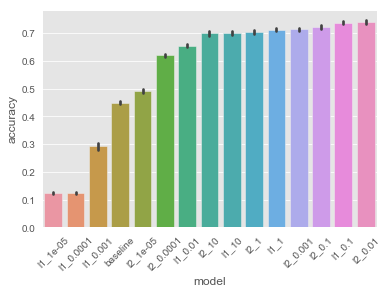

In [32]:
sns.barplot(x='model', y='accuracy',  data=df_accuracies.sort_values('accuracy'))
plt.xticks(rotation=45)

Plot dprimes

In [33]:
d_primes = [c for c in df_accuracies.columns if c[-6:] == 'dprime']
df_dprimes = df_accuracies[[c for c in df_accuracies.columns if c != 'accuracy']] \
    .melt(id_vars=['model', 'split'], value_vars=d_primes, 
          var_name='klass', value_name='score')
df_dprimes['klass'] = df_dprimes['klass'].apply(lambda x: x[:-7])

Let's have a look at d-primes for each class for our three models.

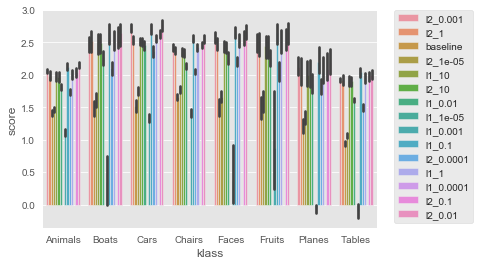

In [34]:
sns.barplot(x='klass', y='score', hue='model', data=df_dprimes)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

This is bit hard to make sense of, let's try another way.

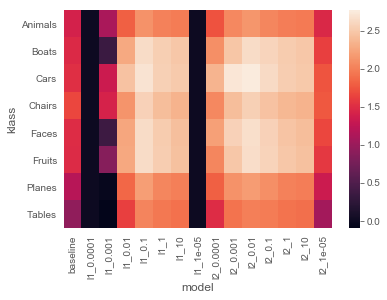

In [35]:
# Draw klass X d_prime score heatmap
d_hm = df_dprimes[['model', 'klass', 'score']] \
    .groupby(['model', 'klass']) \
    .aggregate({np.mean})['score'] \
    .reset_index() \
    .pivot(index='klass', columns='model', values='mean')
sns.heatmap(d_hm)

We can kind of get a better sense of what's happening here -- some klasses are easier for multiple models and `L2_0.01` and `L1_0.1` appear to perform best. We'll verify below...

In [36]:
df_accuracies[['model', 'accuracy']] \
    .groupby('model') \
    .aggregate({np.mean, np.std})['accuracy'] \
    .reset_index() \
    .sort_values('mean', ascending=False)

,model,mean,std
10,l2_0.01,0.738484,0.012180
4,l1_0.1,0.737905,0.008624
11,l2_0.1,0.721933,0.009991
9,l2_0.001,0.714410,0.009180
5,l1_1,0.712963,0.010167
12,l2_1,0.705440,0.012105
6,l1_10,0.700174,0.013341
13,l2_10,0.699016,0.013446
3,l1_0.01,0.654225,0.010002
8,l2_0.0001,0.620139,0.011212


Looks like the best parameterization is the linear SVM with `penalty='L2'` regularization and `C=0.01`. This best model acheives an average accuracy of `0.738484` on my last run.

In general it appears that model is quite sensitive to (either) regularization. That is, we see best performance for both `L1` and `L2` with `C` of `0.1` or `0.01`.

#### Problem 1.2.1.b: Just explore best performaing models

From our runs above we found that the best paramaterizations for each penalty were:
    
    * L2 -> C = 0.01
    * L1 -> C = 0.1
    
We'll now compare our Baseline (no regularization) to our best performing `L1` and `L2`.

In [38]:
# Run models
t0 = time.time()
models = [baseline, LinearSVC(penalty='l2', C=0.01, dual=False), LinearSVC(penalty='l1', C=0.1, dual=False)]
n_splits = 30
test_size = 0.3
model_cms, model_runtimes = run_models_over_n_splits(models, n_splits, X, y, test_size, True)
print("All models ran in {}".format(time.time() - t0))


  0%|          | 0/30 [00:00<?, ?it/s]

Running 3 models over 30 splits.



100%|██████████| 30/30 [02:44<00:00,  5.19s/it]


All models ran in 164.817001104


In [53]:
# Gather data
d_accuracies = []
for model, cms in model_cms.items():
    results = evaluate_results(np.stack(cms), set(y))
    for split, (acc, dprimes) in enumerate(zip(results['accuracy_by_split'], results['dprime_by_split'])):
        d = {'model': model,
             'split': split,
             'accuracy': acc }
        for i, klass in enumerate(set(y)):
            d['{}_dprime'.format(klass)] = dprimes[i]
        d_accuracies.append(d)
df_accuracies = pd.DataFrame(d_accuracies) 
df_accuracies['model'] = df_accuracies['model'].apply(lambda x: x if str(x) != 'l2_1e-10' else 'baseline') 

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

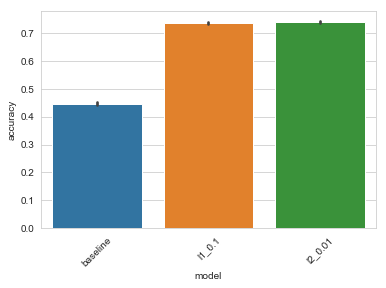

In [54]:
sns.barplot(x='model', y='accuracy',  data=df_accuracies.sort_values('accuracy'))
plt.xticks(rotation=45)

Clearly we're seeing improvements for regularized models. However, it doesn't appear we can distingush between the `L1` and `L2`... We can run a t-tset comparing average accuracy for each model.

In [55]:
stats.ttest_ind(df_accuracies[df_accuracies['model']=='l1_0.1'].accuracy, 
                df_accuracies[df_accuracies['model']=='l2_0.01'].accuracy)

Ttest_indResult(statistic=-0.927869636852461, pvalue=0.35732055125349027)

Simply looking at the distribution over accuracies, we don't see a significant difference between models. This is reflected in our t-test

```
t(29)=-0.93, p=0.36
```

## Problem 1.2.2: Variation levels

Examine how performance depends on variation.

### 1.2.2.a

* Group images into variation levels.
* **For each variation level** - train an SVM with cross-validation and the "best" regularization.
* plot accuracy and d_primes

In [39]:
# Remove bad V4 neurons...
V4_indices = d_ventral['neural_meta']['V4_NEURONS']
bad_v4_indices = V4_indices[-40:]
good_indices = set(range(d_ventral['time_averaged_trial_averaged'][:].shape[1])) - set(bad_v4_indices)

In [41]:
X = d_ventral['time_averaged_trial_averaged'][:, good_indices]
y = d_ventral['image_meta']['category'][:]
labels = set(y)
# Filter by variation level
d_levels = d_ventral['image_meta']['variation_level'][:]
X0 = X[d_levels=='V0', :]
y0 = y[d_levels=='V0']
X3 = X[d_levels=='V3', :]
y3 = y[d_levels=='V3']
X6 = X[d_levels=='V6', :]
y6 = y[d_levels=='V6']
d_variations = {
    'V0': (X0, y0),
    'V3': (X3, y3),
    'V6': (X6, y6) }

From the last problem we're going to train a Linear SVM with `penalty=L2` and `C=0.01`.

In [43]:
# Set model hyperparams
test_split_size = 0.3
best_model_params = {'penalty': 'l2', 'C':0.01, 'dual': False}

In [44]:
# Train models
model_level_variations = {}
for nam, (X_, y_) in d_variations.items():
    model = LinearSVC(**best_model_params)
    X_train, X_test, y_train, y_test =  train_test_split(X_, y_, test_size=test_split_size)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    results = evaluate_results(np.expand_dims(get_confusion_matrix(preds, y_test, labels), 0), labels)
    model_level_variations[nam] = (model, results, X_test, y_test)

In [45]:
# Inspect performance by variation level
d_variation_levels = []
for var_level, (model, results, _, _) in model_level_variations.items():
    d_variation_levels.append({
        'var_level': var_level,
        'accuracy': results['mean_accuracy']
    })
    for i, lab in enumerate(labels):
        d_variation_levels[-1][lab] = results['mean_dprime'][i]
    
df_variation_levels = pd.DataFrame(d_variation_levels)

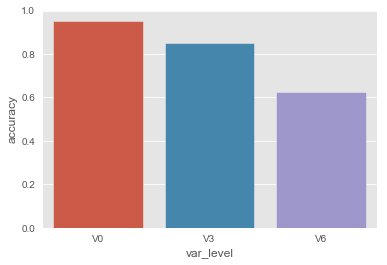

In [46]:
# Accuracy plot
sns.barplot(x='var_level', y='accuracy', data=df_variation_levels)

In [47]:
# Gather dprime data
d_primes = [c for c in df_variation_levels.columns if c not in ['accuracy', 'var_level']]
df_dprime_plot = df_variation_levels[d_primes + ['var_level']] \
    .melt(id_vars=['var_level'], value_vars=d_primes, 
          var_name='klass', value_name='dprime')

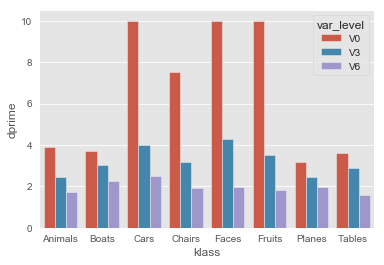

In [48]:
# Dprime performance by klass by variation level
sns.barplot(x='klass', y='dprime', hue='var_level', data=df_dprime_plot)

### 1.2.2.b

* Explore generalization performance across levels
* Train SVM model with regularization on all images belonging to one variation level and test it on images of another level.

First we'll create train/test splits for each variation level.

In [50]:
var_levels = set({'V0', 'V3', 'V6'})

d_generalizations = []
for var_level, (model, _, X_test, y_test) in model_level_variations.items():
    for other_level in var_levels:
        X_test, y_test = model_level_variations[other_level][-2:]
        labels = set(y_test)
        res = evaluate_results(np.expand_dims(get_confusion_matrix(model.predict(X_test), y_test, labels), 0), labels)
        d_generalizations.append({
            'train_variation': var_level,
            'test_variation': other_level,
            'accuracy': res['mean_accuracy']
        })
        
df_generalizations = pd.DataFrame(d_generalizations)   

**Note** the question only asks us to plot validation accuracies...

test_variation         V0        V3        V6
train_variation                              
V0               0.953125  0.588542  0.320312
V3               0.843750  0.848958  0.531250
V6               0.645833  0.722656  0.623698


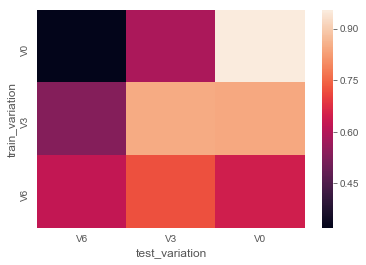

In [51]:
# Plot generalizations
df_generalizations_as_matrix = \
    df_generalizations.pivot(index='train_variation', columns='test_variation', values='accuracy')
print(df_generalizations_as_matrix)
sns.heatmap(df_generalizations_as_matrix[['V6', 'V3', 'V0']])

Some observations -- training on the same variation we see the best performance for each variation level. That is training on `V0` means we perform best on `V0`. Same for `V3` and `V6`. Noteably, performance is overall much better on the lowest `V0`. If we train on `V0` we tend to perform much worse on `V6` than if we had trained on `V3`.

In [52]:
df_generalizations \
    .groupby('train_variation') \
    .aggregate({np.mean})

,accuracy
,mean
train_variation,
V0,0.620660
V3,0.741319
V6,0.664062


Just an observation, if we had to pick one variation level to train on for best generalization we should `V3` looking at aggregate accuracy over all levels.

## Problem 1.2.3: Visual areas

How performances compare between neurons from the two cortical areas.


### 1.2.3.a

Group the neurons by areas using “IT NEURONS” and “V4 NEURONS” in “neural meta”. Then train SVM models with regularization on V4 and IT neurons separately. Please plot the validation accuracies in a barchart, generating error bars for each area across cross-validation image splits. Are the accuracies for two areas different? Using significance test to give an answer and report the test result properly. How do you interpret these results?

In [56]:
# Remove bad V4 neurons...
V4_indices = d_ventral['neural_meta']['V4_NEURONS']
bad_v4_indices = V4_indices[-40:]; bad_v4_indices
good_indices = set(range(d_ventral['time_averaged_trial_averaged'][:].shape[1])) - set(bad_v4_indices)

In [57]:
# Prep data
X = d_ventral['time_averaged_trial_averaged'][:, good_indices]
y = d_ventral['image_meta']['category'][:]
labels = set(y)
# Filter by ROI
it_neuron_idxs = \
    list(set(d_ventral['neural_meta']['IT_NEURONS'][:]) & set(good_indices))
v4_neuron_idxs = \
    list(set(d_ventral['neural_meta']['V4_NEURONS'][:]) & set(good_indices))
assert len(it_neuron_idxs) + len(v4_neuron_idxs) == X.shape[1]
X_it = X[:, it_neuron_idxs]
X_v4 = X[:, v4_neuron_idxs]
y_it = y[:]
y_v4 = y[:]

d_roi = {'it': (X_it, y_it), 'v4': (X_v4, y_v4)}

Let's train using our parameters found from part 1.2.1

In [58]:
n_splits = 30
test_split_size = 0.3
best_model_params = {'penalty': 'l2', 'C':0.01, 'dual': False}
d_roi_results = {}
for roi, (X, y) in d_roi.items():
    model = LinearSVC(**best_model_params)
    model_results, _ = run_models_over_n_splits([model], n_splits, X, y, test_size=test_split_size)
    res = evaluate_results(np.stack(model_results.values()[0]), set(y))
    accuracies = res['accuracy_by_split']
    average_cm = res['confusion_matrices'].mean(0)
    d_roi_results[roi] = (model, accuracies, average_cm)


  0%|          | 0/30 [00:00<?, ?it/s]

Running 1 models over 30 splits.



100%|██████████| 30/30 [00:12<00:00,  2.37it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Running 1 models over 30 splits.



100%|██████████| 30/30 [00:17<00:00,  1.73it/s]


Accuracies plot

In [59]:
df_accuracies = pd.DataFrame.from_dict({
    'roi': ['IT' for _ in range(len(d_roi_results['it'][1]))] + \
            ['V4' for _ in range(len(d_roi_results['v4'][1]))],
    'accuracy': d_roi_results['it'][1] + d_roi_results['v4'][1],
    'split': range(len(d_roi_results['it'][1])) + range(len(d_roi_results['v4'][1]))
})
df_accuracies \
    .groupby('roi') \
    .aggregate({np.mean, np.std})['accuracy'] \
    .reset_index()

,roi,mean,std
0,IT,0.732870,0.009963
1,V4,0.405015,0.010560


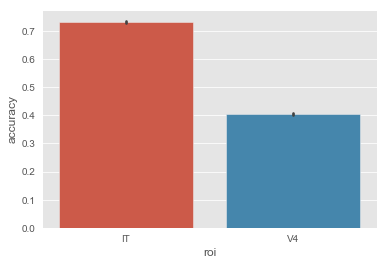

In [60]:
sns.barplot(x='roi', y='accuracy', ci=95, data=df_accuracies)

In [61]:
it_accuracies = df_accuracies[df_accuracies['roi']=='IT'].accuracy
v4_accuracies = df_accuracies[df_accuracies['roi']=='V4'].accuracy
n1 = len(it_accuracies)
n2 = len(v4_accuracies)
dof = n1 + n2 - 2
print('dof {}'.format(dof))
stats.ttest_ind(it_accuracies, v4_accuracies, equal_var=False)
stats.ttest_ind(it_accuracies, v4_accuracies)

dof 58


Ttest_indResult(statistic=123.69317219417414, pvalue=5.686620727793913e-72)

Clearly looks like there's a region-level difference it accuracy on `IT` far higher. We can compare formally running a ttest. IT accuracies are significantly higher.

```
t(58)=123.69, p<1e-10
```

We can interpret this in the following way -- in terms of object category level classification `IT` data provides significantly more signal than `V4`.


### 1.2.3.b

Compute the average confusion matrices over multiple splits for both V4 and IT neurons. Visualize the confusion matrices separately. Are the matrices different?

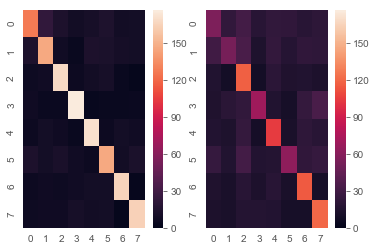

In [82]:
# Grab confusion matrices
it_cm = d_roi_results['it'][2]
v4_cm = d_roi_results['v4'][2]
vmax = max(max(it_cm.reshape(-1)), max(v4_cm.reshape(-1)))

plt.subplot(1, 2, 1)
sns.heatmap(it_cm, vmin=0, vmax=vmax)
plt.subplot(1, 2, 2)
sns.heatmap(v4_cm, vmin=0, vmax=vmax)

Qualitatively the heatmaps look quite different! While the majority of the values lie on the diagonal for `IT` (since accuracies are pretty high), the same cannot be said for `V4`. Note the sight differences in the scales as well.

In [84]:
df_cms = pd.DataFrame.from_dict({
    'IT': it_cm.reshape(-1).tolist(),
    'V4': v4_cm.reshape(-1).tolist()
})

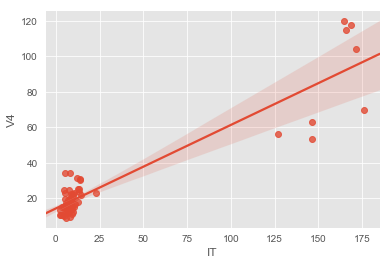

In [87]:
sns.regplot(x='IT', y='V4', data=df_cms)

In [88]:
print('r: {}'.format(round(stats.pearsonr(df_cms.IT, df_cms.V4)[0], 3)))

r: 0.924


Clearly there is a relationship between V4 and IT confusions. So that means that even though accuracies in `IT` are much higher, if there is a misclassification, the same misclassification was likley made in `V4`.

### 1.2.3.c

Make plot a scatter plot of confusion matrix values for corresponding items between the V4 and IT matrices. Make the scatter plots separately for the diagonal terms and the off-diagonal terms of the confusion matrices, and interpret your findings.

In [90]:
it_diag = np.diagonal(it_cm)
v4_diag = np.diagonal(v4_cm)
it_off_diag = it_cm[~np.eye(it_cm.shape[0], dtype=bool)].reshape(-1)
v4_off_diag = v4_cm[~np.eye(v4_cm.shape[0], dtype=bool)].reshape(-1)

Text(0.5,1,'Off-Diagonal r: 0.462')

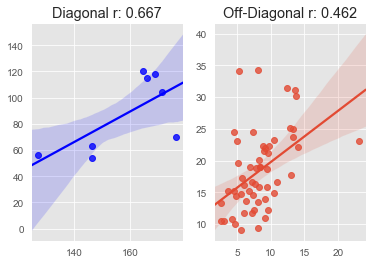

In [91]:
# Plot diagonal and off-diagonal correlations
r_diag = stats.pearsonr(it_diag, v4_diag)[0]
r_off_diag = stats.pearsonr(it_off_diag, v4_off_diag)[0]
plt.subplot(121)
sns.regplot(it_diag, v4_diag, color='blue')
plt.title("Diagonal r: {}".format(round(r_diag, 3)))
plt.subplot(122)
sns.regplot(it_off_diag, v4_off_diag)
plt.title("Off-Diagonal r: {}".format(round(r_off_diag, 3)))

This is kind of suprising -- the individual correlation values are lower than the overall... The scales are quite different here, which I think is leading to some issues. Let's have them share the same axis limits.

Text(0.5,1,'Off-Diagonal r: 0.462')

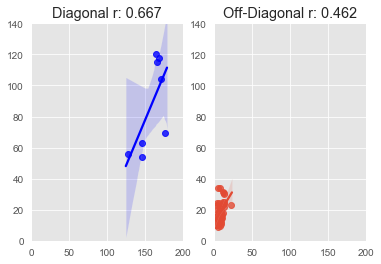

In [92]:
# Plot diagonal and off-diagonal correlations
r_diag = stats.pearsonr(it_diag, v4_diag)[0]
r_off_diag = stats.pearsonr(it_off_diag, v4_off_diag)[0]
plt.subplot(121)
sns.regplot(it_diag, v4_diag, color='blue')
plt.ylim(0, 140)
plt.xlim(0, 200)
plt.title("Diagonal r: {}".format(round(r_diag, 3)))
plt.subplot(122)
sns.regplot(it_off_diag, v4_off_diag)
plt.ylim(0, 140)
plt.xlim(0, 200)
plt.title("Off-Diagonal r: {}".format(round(r_off_diag, 3)))

These groups are so vastly different, correlation may obscure (inflate) the similarities artificially.